In [1]:
import torch.fft as fft
import torch
import cv2 as cv
import os
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def loadata(path):
    calibrate_data = torch.load(path)
    mean = torch.tensor([0.485, 0.456, 0.406]).unsqueeze(1).unsqueeze(2).unsqueeze(0).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).unsqueeze(1).unsqueeze(2).unsqueeze(0).cuda()
    data = (calibrate_data * std.expand_as(calibrate_data)) + mean.expand_as(calibrate_data)
    return data

def saveimg(name, data):
    cv.imwrite(name, (data.permute(1, 2, 0)*255).cpu().detach().numpy())

def fftmask(r1, r2, r3):
    S = 224
    R = S // 2
    R1 = R * r1
    R2 = R * r2
    R3 = R * r3
    lmask = torch.zeros((S, S))
    hmask = torch.zeros((S, S))
    for i in range(S):
        for j in range(S):
            dis = (i - (S - 1) / 2) ** 2 + (j - (S - 1) / 2) ** 2
            if (dis <= R1 ** 2):
                lmask[i, j] = 1
            if (dis <= R2 ** 2 and dis >= R3 ** 2):
                hmask[i, j] = 1
    lmask, hmask = lmask.cuda(), hmask.cuda()
    return lmask, hmask

def imgfft(calibrate_data, lmask, hmask):
    h, w = calibrate_data.shape[-2], calibrate_data.shape[-1]
    f = fft.fftn(calibrate_data, dim=(2,3))
    f = torch.roll(f, (h // 2, w // 2), dims=(2, 3))
    data_l = f * lmask
    data_h = f * hmask
    data_l = torch.abs(fft.ifftn(data_l, dim=(2, 3)))
    data_h = torch.abs(fft.ifftn(data_h, dim=(2, 3)))
    return data_l, data_h

def GetGrad(img):
    transform = transforms.Compose([
    transforms.Grayscale()])
    image = transform(img)
    sobel_x = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).cuda()
    sobel_y = torch.Tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]).cuda()
    gradient_x = torch.nn.functional.conv2d(image, sobel_x.unsqueeze(0).unsqueeze(0))
    gradient_y = torch.nn.functional.conv2d(image, sobel_y.unsqueeze(0).unsqueeze(0))
    gradient_magnitude = torch.sqrt(gradient_x.pow(2) + gradient_y.pow(2))
    gradient_magnitude = gradient_magnitude / gradient_magnitude.max()

    return gradient_magnitude

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
modelname = 'swin_small'
if not os.path.exists('visualization'):
    os.mkdir('visualization')

In [4]:
# show calibrate data and it's high-frequency gradient
if not os.path.exists('visualization/img'):
    os.mkdir('visualization/img')

# FDD
calibrate_data = loadata(f"calibrate_data/{modelname}.pt")
lmask, hmask = fftmask(0.6, 1, 0.6)
_, img_h = imgfft(calibrate_data, lmask, hmask)
g_img_h = GetGrad(img_h)
for i in range(3):
    saveimg(f'visualization/img/FDD_{i}.jpg', calibrate_data[i])
    saveimg(f'visualization/img/FDD_g_{i}.jpg', g_img_h[i])

# PSAQ
calibrate_data = loadata(f"calibrate_data/{modelname}_syn.pt")
lmask, hmask = fftmask(0.6, 1, 0.6)
_, img_h = imgfft(calibrate_data, lmask, hmask)
g_img_h = GetGrad(img_h)
for i in range(3):
    saveimg(f'visualization/img/PSAQ_{i}.jpg', calibrate_data[i])
    saveimg(f'visualization/img/PSAQ_g_{i}.jpg', g_img_h[i])

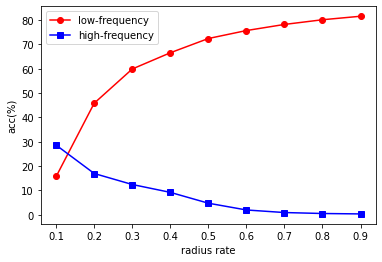

In [5]:
# low-frequency vs. high-frequency
if not os.path.exists('visualization/analyse'):
    os.mkdir('visualization/analyse')

x = np.arange(0.1, 1, 0.1)
y_lf = [15.698, 45.820, 59.876, 66.544, 72.402, 75.678, 78.188, 80.116, 81.556]
y_hf = [28.584, 16.926, 12.406, 9.176, 4.720, 1.938, 0.882, 0.488, 0.318]

plt.plot(x, y_lf, 'o-', color='r', label='low-frequency')
plt.plot(x, y_hf, 's-', color='b', label='high-frequency')
plt.xlabel('radius rate')
plt.ylabel('acc(%)')
plt.legend()
plt.savefig('visualization/analyse/lf_vs_hf.pdf')

[0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


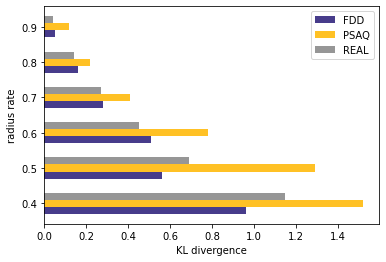

In [6]:
# FDD vs. PSAQ
if not os.path.exists('visualization/analyse'):
    os.mkdir('visualization/analyse')

x = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
real = [1.15, 0.69, 0.45, 0.27, 0.14, 0.04]
syn = [1.52, 1.29, 0.78, 0.41, 0.22, 0.12]
fdd = [0.96, 0.56, 0.51, 0.28, 0.16, 0.05]

height = 0.2
a1 = list(range(len(x)))
a2 = [i+height for i in a1]
a3 = [i+height*2 for i in a1]

plt.barh(a1, fdd, height= height, label = "FDD", color = "#473C8B")
plt.barh(a2, syn, height= height, label = "PSAQ", color = "#FFC125")
plt.barh(a3, real, height= height, label = "REAL", color = "#969696")

plt.yticks(a2, x)
print(x)
plt.legend()

plt.xlabel("KL divergence")
plt.ylabel("radius rate")

plt.savefig('visualization/analyse/FDD_vs_PSAQ.pdf')